Setup

In [1]:
import sys
!{sys.executable} -m pip install -U deepposekit

Requirement already up-to-date: deepposekit in c:\users\pranavm\anaconda3\lib\site-packages (0.3.4)


In [2]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint


import time
from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'
HOME = HOME +'/Documents/RamanLab'

In [3]:
glob.glob(HOME + '/deepposekit-data/**/**/*annotation*.h5')

['C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data\\datasets\\locust\\annotation_data_release.h5']

DataGenerator

In [4]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/annotation_data_release.h5')

C:\Users\PranavM\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


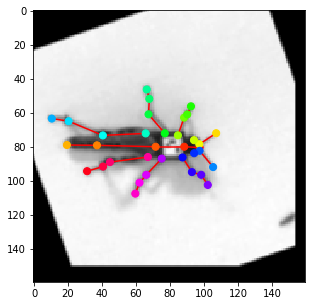

In [5]:
image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

Augmentation Pipeline

In [6]:
augmenter = []

augmenter.append(FlipAxis(data_generator, axis=0))  # flip image up-down
augmenter.append(FlipAxis(data_generator, axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)

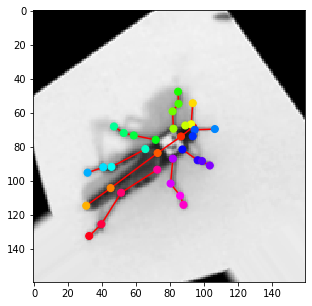

In [7]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

In [8]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=3,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 630,
 'n_validation': 70,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (20, 20),
 'n_output_channels': 72,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/annotation_data_release.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 700,
 'image_shape': (160, 160, 1),
 'keypoints_shape': (35, 2)}

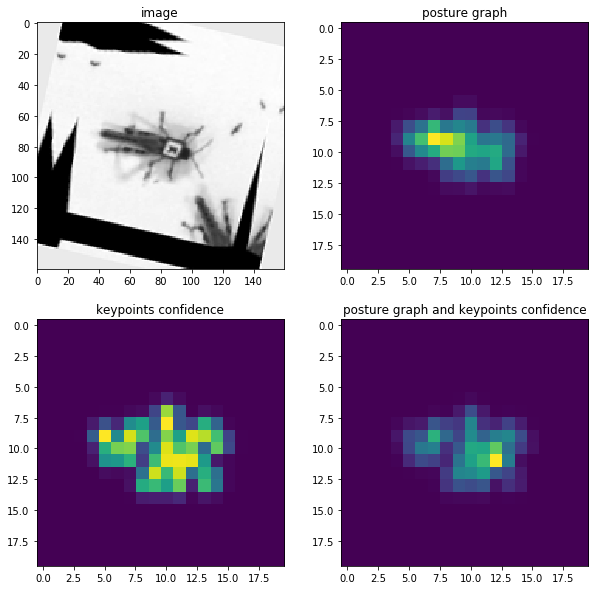

In [9]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

Build Model
    StackedDenseNet? - For more info on StackedDenseNet
    DeepLabCut? - For more info on DeepLabCut

In [10]:
from deepposekit.models import DeepLabCut, StackedDenseNet, StackedHourglass, LEAP

In [11]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)

#model = DeepLabCut(train_generator, backbone="resnet50")
#model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35) # Increase alpha to improve accuracy
#model = DeepLabCut(train_generator, backbone="densenet121")

#model = LEAP(train_generator)
#model = StackedHourglass(train_generator)

model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 5,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 630,
 'n_validation': 70,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (20, 20),
 'n_output_channels': 72,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'C:\\Users\\PranavM/Documents/RamanLab/deepposekit-data/datasets/locust/annotation_data_release.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 700,
 'image_shape': (160, 160, 1),
 'keypoints_shape': (35, 2)}

In [12]:
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:100], batch_size=100) # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=100, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 48s 5ms/sample
208.55276235659395


In [13]:
logger = Logger(validation_batch_size=10,
    # filepath saves the logger data to a .h5 file
    # filepath=HOME + "/deepposekit-data/datasets/fly/log_densenet.h5"
)

If validation_split=0 for your TrainingGenerator, which will just use the training set for model fitting, make sure to set monitor="loss" instead of monitor="val_loss".

Logger evaluates the validation set (or training set if validation_split=0 in the TrainingGenerator) at the end of each epoch and saves the evaluation data to a HDF5 log file (if filepath is set).

In [14]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)

In [15]:
model_checkpoint = ModelCheckpoint(
    HOME + "/deepposekit-data/datasets/locust/best_model_densenet.h5",
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_best_only=True,
)

In [16]:
early_stop = EarlyStopping(
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1
)

In [17]:
callbacks = [early_stop, reduce_lr, model_checkpoint, logger]

Fit the Model

model.fit(
    batch_size=16,
    validation_batch_size=10,
    callbacks=callbacks,
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=200,
    n_workers=8,
    steps_per_epoch=None,
)

Load and Resume Training

In [18]:
model = load_model(
    HOME + "/deepposekit-data/datasets/locust/best_model_densenet.h5",
    augmenter=augmenter,
    generator=data_generator,
)

model.fit(
    batch_size=5,
    validation_batch_size=10,
    callbacks=callbacks,
    epochs=30,
    n_workers=8,
    steps_per_epoch=None,
)

In [ ]:
model.fit(
    batch_size=16,
    validation_batch_size=10,
    callbacks=callbacks,
    epochs=32,
    n_workers=8,
    steps_per_epoch=None,
)

Epoch 1/32
38/39 [============================>.] - ETA: 0s - loss: 32.9825 - output_0_loss: 12.8462 - output_1_loss: 10.6670 - output_2_loss: 9.4692
Epoch 00001: val_loss did not improve from 38.43210
evaluation_metrics: 
euclidean - mean:  1.27 (0%:  0.01, 5%:  0.21, 25%:  0.52, 50%:  0.88, 75%:  1.42, 95%:  3.19, 100%: 41.46) 
confidence - mean:  0.80 (0%:  0.08, 5%:  0.60, 25%:  0.72, 50%:  0.80, 75%:  0.89, 95%:  0.99, 100%:  1.08) 

39/39 [==============================] - 36s 932ms/step - loss: 32.9387 - output_0_loss: 12.8306 - output_1_loss: 10.6523 - output_2_loss: 9.4558 - val_loss: 39.4103 - val_output_0_loss: 14.4490 - val_output_1_loss: 12.7394 - val_output_2_loss: 12.2218
Epoch 2/32
38/39 [============================>.] - ETA: 0s - loss: 33.8479 - output_0_loss: 13.1439 - output_1_loss: 10.9699 - output_2_loss: 9.7342
Epoch 00002: val_loss did not improve from 38.43210
evaluation_metrics: 
euclidean - mean:  1.25 (0%:  0.00, 5%:  0.20, 25%:  0.52, 50%:  0.88, 75%:  1.41

Epoch 13/32
38/39 [============================>.] - ETA: 0s - loss: 32.8173 - output_0_loss: 12.8366 - output_1_loss: 10.6022 - output_2_loss: 9.3784
Epoch 00013: val_loss did not improve from 38.43210
evaluation_metrics: 
euclidean - mean:  1.27 (0%:  0.00, 5%:  0.21, 25%:  0.53, 50%:  0.87, 75%:  1.41, 95%:  3.21, 100%: 40.03) 
confidence - mean:  0.80 (0%:  0.10, 5%:  0.60, 25%:  0.72, 50%:  0.80, 75%:  0.89, 95%:  0.99, 100%:  1.07) 

39/39 [==============================] - 38s 983ms/step - loss: 32.8801 - output_0_loss: 12.8518 - output_1_loss: 10.6238 - output_2_loss: 9.4044 - val_loss: 39.2325 - val_output_0_loss: 14.4113 - val_output_1_loss: 12.6945 - val_output_2_loss: 12.1267
Epoch 14/32
38/39 [============================>.] - ETA: 0s - loss: 32.4441 - output_0_loss: 12.6573 - output_1_loss: 10.4992 - output_2_loss: 9.2876
Epoch 00014: val_loss did not improve from 38.43210
evaluation_metrics: 
euclidean - mean:  1.29 (0%:  0.01, 5%:  0.22, 25%:  0.53, 50%:  0.87, 75%:  1.